In [1]:
#--- Import libraries ---

#libs for calculation and data handling
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import numpy.linalg as lina

#libs for plotting and visualisation
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib as mat

#libs for machine learning
from sklearn.cluster import KMeans

# CS342 Machine Learning

# Assignment: Gaussian Mixture Modelling for Clustering

First, we define two auxiliary functions:

1. `draw_ellipse`: plotting 5 ellipses of of varying size with given position and covariance,
2. `PCA_decomp`: calculate the SVD of a given feature matrix and return the top $k$ principle components.

In [2]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [3]:
def PCA_decomp(X, k):
    """Return the top k PCs for a given feature matrix"""
    #centering the features
    mu = np.mean(X, axis=0)
    X_cent = X - mu
    
    U, S, V = np.linalg.svd(X_cent, full_matrices=True)
    
    return V[:k,:]

The cell below deals with importing the data set and computing its PCA using the top 2 principle components. Then we scatter-plot the coordinates in that new 2D basis and colour the data points according to their groud truth class. 

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


[]

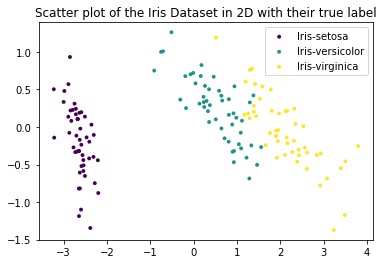

In [4]:
#--- Data visualisation and PCA (II.B) ---

#import data and read to data frame
df = pd.read_csv('iris.data', header = None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
print(df.head())

#centre data
df.iloc[:,0:4] = df.iloc[:,0:4].apply(lambda x: x-x.mean())


#numerize class column
d = dict(zip(df['class'].unique(), range(0,3)))
y = df['class'].map(d, na_action='ignore')

#calculate the top 2 PCs and the coordinates of the feature vectors in df wrt W
W = PCA_decomp(df.iloc[:,0:4], 2)
Z2 = df.iloc[:,0:4].dot(np.transpose(W))
Z2['class'] = y

#scatter plot the points in Z2 and colour them according to their label
cmap = plt.cm.viridis
norm = plt.Normalize(y.values.min(), y.values.max())

for i, dff in Z2.groupby("class"):
    if i == 0:
        l = 'Iris-setosa'
    elif i == 1:
        l = 'Iris-versicolor'
    elif i == 2:
        l = 'Iris-virginica'
    plt.scatter(dff.iloc[:,0], dff.iloc[:,1], s=15, c=cmap(norm(dff['class'])), 
                edgecolors='none', label=l)
plt.legend()
plt.title('Scatter plot of the Iris Dataset in 2D with their true label')
plt.plot()

The cell below fits a `k-means` model onto the 2D data points calculated above. The circular patches in the plot display the shape of the clusters. Their centre is the respective mean of a cluster and the radius the distance to the most distant point in that cluster.

Finally, we calculate the accuracy of the kmeans model.

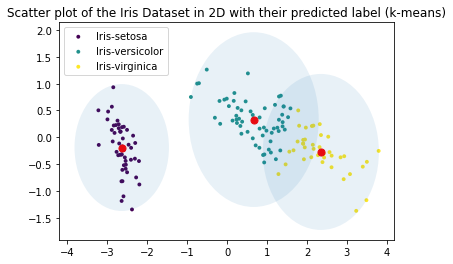

The number of misclassifications is: 17.0.
The accuracy of the model is: 0.887 (to 3dp).


In [5]:
#train a k-means model to fit the data points in Z2
k = 3
X = Z2.iloc[:,0:2].to_numpy()

kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
km_centres = kmeans.cluster_centers_
            
#scatter plot the points in Z2 and colour them according to their predicted label
Z2['pred_class_km'] = kmeans.labels_
cmap = plt.cm.viridis
norm = plt.Normalize(y.values.min(), y.values.max())

for i, dff in Z2.groupby("pred_class_km"):
    if i == 0:
        l = 'Iris-setosa'
    elif i == 1:
        l = 'Iris-versicolor'
    elif i == 2:
        l = 'Iris-virginica'
    plt.scatter(dff.iloc[:,0], dff.iloc[:,1], s=15, c=cmap(norm(dff['pred_class_km'])), 
                edgecolors='none', label=l)
plt.legend()

#find the most distant point from each cluster centre
labels = kmeans.labels_
max_dist = [0, 0, 0]

for c in range(k):
    for i in range(X.shape[0]):
        if labels[i] == c and (lina.norm(X[i] - km_centres[c]) > max_dist[c]):
            max_dist[c] = lina.norm(X[i] - km_centres[c])

#draw the circular patches and the cluster centres
ax = plt.gca()
for c in range(k):
    circ = plt.Circle(km_centres[c], max_dist[c], alpha=0.1)
    ax.add_patch(circ)
plt.scatter(km_centres[:,0], km_centres[:,1], 50, c='r')
plt.title('Scatter plot of the Iris Dataset in 2D with their predicted label (k-means)')
plt.show()

#calculate the accuracy of the kmeans model
misclass = lina.norm(kmeans.labels_ - y, ord=1)
print('The number of misclassifications is: ' + str(misclass) + '.')
perc = 1 - misclass / X.shape[0]
print('The accuracy of the model is: ' + str(round(perc, 3)) + ' (to 3dp).')

This cell implements the `GMM_EM` class, our implementation of the EM algorithm applied to GMM.

In [6]:
class GMM_EM():
    '''Gaussian Mixture Modelling with the E-M-algorithm'''
    def __init__(self, num_centres, num_samples, tol):
        self.k = num_centres
        self.n = num_samples
        self.pi = None
        self.means = None
        self.cov = None
        self.resp = [0]*self.k
        self.prev_resp = [0]*self.k
        self.tol = tol
        self.iter = 0
        self.ll = []
        
    def fit(self, X, init_centres): 
        '''Train the GMM model using the EM algorithm'''
        #initialise variabes
        pi = np.array([1 / k] * k)
        mu = np.zeros(X.shape[1]*k).reshape(k, X.shape[1])
        sigma = [np.eye(X.shape[1])]*k
        
        #find initial parameters pi, mu, sigma using the initial responsibility r_i_c
        r_i_c = self.calc_resp(X, sigma, init_centres, pi, self.k)
        
        for c in range(k):
            sum1 = r_i_c[:,c].sum()
            pi[c] = sum1/self.n
            mu[c] = np.sum(r_i_c[:,c]*X.T, axis = 1)/sum1
            sigma[c] = (r_i_c[:,c]*(((X - mu[c]).T)) @ (X - mu[c]))/sum1
        
        #update model parameters to initial parameters
        self.pi = pi
        self.means = mu
        self.cov = sigma
        self.resp = r_i_c

        #print initial parameters
        print('The initial set of parameters is:')
        print('Pi_c:')
        print(gmm.pi)
        print('Mu_c:')
        for c in range(k):
            print(gmm.means[c])
        print('Sigma_c:')
        for c in range(k):
            print(gmm.cov[c])
                    
        while (not (lina.norm(self.resp - self.prev_resp) < self.tol)): 
            
            #--- E-step ---
            
            #calculate responsibilities
            r_i_c = self.calc_resp(X, self.cov, self.means, self.pi, self.k)
            
            #--- M-step ---
            for c in range(self.k):
                sum1 = r_i_c[:,c].sum()
                pi[c] = sum1/self.n
                mu[c] = np.sum(r_i_c[:,c]*X.T, axis = 1)/sum1
                sigma[c] = (r_i_c[:,c]*(((X - mu[c]).T)) @ (X - mu[c]))/sum1
            
            #update model parameters
            self.pi = pi
            self.means = mu
            self.cov = sigma
            self.iter += 1         
            self.prev_resp = self.resp.copy()
            self.resp = r_i_c
            
            #calculate latest value of objective function
            self.ll.append(self.obj_fun(r_i_c, X, self.means, self.cov))
             
    def predict(self, X):
        '''Use the trained model to hard-assign the points in X'''
        r_i_c = self.calc_resp(X, self.cov, self.means, self.pi, self.k)
        y_hat = np.argmax(r_i_c, axis=1)
        
        return y_hat

    def misclass_accuracy(self, X, y):
        '''Calculate the number of misclassifications and accuracy'''
        misclass = lina.norm(gmm.predict(X)-y.copy(), ord=1)
        acc = 1 - misclass / X.shape[0]
        
        return misclass, acc

    def calc_resp(self, X, sig, mu, pi, k):
        '''Calculate the responsibilities for given paramters'''
        r_i_c = np.zeros((X.shape[0], k))

        for i in range(X.shape[0]):
            den = 0
            for j in range(k):
                den += pi[j]*multivariate_normal.pdf(X[i,:], mu[j], sig[j])

            for j in range(k):
                num = pi[j]*multivariate_normal.pdf(X[i,:], mu[j], sig[j])
                r_i_c[i][j] = num/den
                   
        return r_i_c
    
    def obj_fun(self, resp, X, mu, sig):
        '''Calculate the objective function for given paramters'''
        obj = 0
        for i in range(self.n):
            tmp = 0
            for c in range(self.k):
                tmp += resp[i,c] * np.log(multivariate_normal.pdf(X[i,:], mu[c], sig[c]))
            obj += tmp
        return -obj

The cell below fits the `GMM_EM` model onto the 2D datapoints calculated above. We print the initial and final parameters aswell as the number of misclassifications and and accuracy.
The plot show the new assignment of the datapoints into clusters and their shape. At the end, we also plot the objective funtion as a function of the number of iterations.

The initial set of parameters is:
Pi_c:
[0.34069116 0.36648244 0.29282639]
Mu_c:
[-2.58521701 -0.16571157]
[0.79047386 0.27687628]
[ 2.0184854 -0.1537219]
Sigma_c:
[[ 0.17057513 -0.0051807 ]
 [-0.0051807   0.23436467]]
[[ 0.62890798 -0.17870994]
 [-0.17870994  0.16948743]]
[[ 0.71396185 -0.23236636]
 [-0.23236636  0.18542952]]


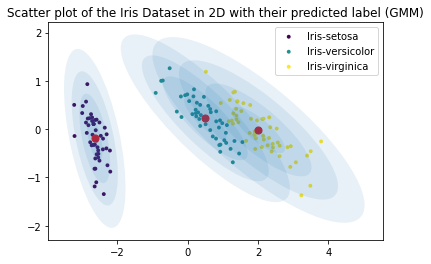

The final set of parameters is:
Pi_c:
[0.33333333 0.30582335 0.36084331]
Mu_c:
[-2.64084076 -0.19051995]
[0.50260018 0.22583677]
[ 2.01354259 -0.01540699]
Sigma_c:
[[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
[[ 0.3615557  -0.21809301]
 [-0.21809301  0.18882384]]
[[ 0.56883409 -0.29346654]
 [-0.29346654  0.23147093]]
The EM algorithm converged in 22 iterations.
The number of misclassifications is: 3.0.
The accuracy of the model is: 0.98 (to 3dp).


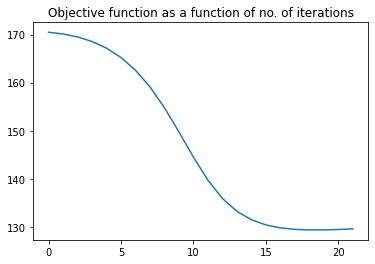

The objective function is minimized after 18 iterations.


In [7]:
#--- train GMM model ---

#initialise variables and parameters and take them to a better format
X = Z2.iloc[:,0:2].to_numpy()
y = df['class'].map(d, na_action='ignore')
k = 3
n = X.shape[0]
tol = 10**(-1)

#train and fit GMM model
gmm = GMM_EM(k, n, tol)
gmm.fit(X, km_centres)
Z2['pred_class_gmm'] = gmm.predict(X)

#--- visualize GMM model ---

#replot the points in Z2, coloured according to their predicted label by GMM_EM
cmap = plt.cm.viridis
norm = plt.Normalize(y.values.min(), y.values.max())

for i, dff in Z2.groupby("pred_class_gmm"):
    if i == 0:
        l = 'Iris-setosa'
    elif i == 1:
        l = 'Iris-versicolor'
    elif i == 2:
        l = 'Iris-virginica'
    plt.scatter(dff.iloc[:,0], dff.iloc[:,1], s=15, c=cmap(norm(dff['pred_class_gmm'])), 
                edgecolors='none', label=l)
plt.scatter(gmm.means[:,0], gmm.means[:,1], 50, c='r')
plt.title('Scatter plot of the Iris Dataset in 2D with their predicted label (GMM)')
plt.legend()

#draw elliptical shapes of the clusters
alpha_factor = 1/10;
for c in range(k):
    draw_ellipse(gmm.means[c], gmm.cov[c], alpha = alpha_factor)
plt.show()

#--- calculate and analyse metrics ---

#display the final set of parameters and number of iterations
print('The final set of parameters is:')
print('Pi_c:')
print(gmm.pi)
print('Mu_c:')
for c in range(k):
    print(gmm.means[c])
print('Sigma_c:')
for c in range(k):
    print(gmm.cov[c])
print('The EM algorithm converged in ' + str(gmm.iter) + ' iterations.')
    
#determine number of missclassifications and calculate accuracy
misclass, acc = gmm.misclass_accuracy(X, y)
print('The number of misclassifications is: ' + str(misclass) + '.')
print('The accuracy of the model is: ' + str(round(acc, 3)) + ' (to 3dp).')

#plot the objective function as function of no. of iterations
plt.plot(gmm.ll)
plt.title('Objective function as a function of no. of iterations')
plt.show()
print('The objective function is minimized after ' + str(min(range(len(gmm.ll)), key=gmm.ll.__getitem__)) + ' iterations.')

We use this part to find the best tolerance for our model by creating a `GMM` model for different tolerances and plotting their accuracies. It is commented out due to its long running time and the generated plot can be found in the report.

In [8]:
#%%capture
#--- hyperparameter-like approach to find a good value for the tolerance ---

#calculate accuracies for a range of values of gmm.tol
#acc = []
#for i in range(10):
#    gmm = GMM_EM(k, n, 10**(-i));
#    gmm.fit(X, km_centres);
#    _, a = gmm.misclass_accuracy(X, y)
#    acc.append(a)   

#plot the accuracy as a function of the tolarance
#fig = plt.figure()
#plt.plot(acc)
#locs, labels = plt.xticks()
#labels = [10**(-float(item)) for item in locs]
#plt.xticks(locs[1:], labels[1:])
#plt.show()